In [1]:
import torch

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import pytorch_lightning.callbacks as cb

from models.configurations import TEXT_PRETRAINED, VISION_PRETRAINED
from models.finetuner import AdaptorFinetuner
from models.adaptor import Adaptor
from utils.model_utils import get_newest_ckpt, StreamingProgressBar
from dataset.dataset import clf_collator
from dataset.configurations import DATASET_CFG
from dataset.data_module import AdaptorDataModule
from utils.args import get_train_parser
from utils.model_utils import load_vision_model

import numpy as np

In [2]:
vision_model = "resnet-ae"
text_model = "bert"
# dataset = "rsna"
dataset = "covidx"

vision_model_config = VISION_PRETRAINED[vision_model]
vision_pretrained = vision_model_config["pretrained_weight"]
vision_model_type = vision_model_config["vision_model_type"]

dataset_cfg = DATASET_CFG["clf"][dataset]
dataset_class = dataset_cfg["class"]
dataset_kwargs = dataset_cfg["kwargs"]
data_transform = vision_model_config["data_transform"]

In [12]:
# adaptor_ckpt = get_newest_ckpt(
#     vision_model, text_model, postfix="v2", 
#     project_name="adaptor_pretrain_2_layers", 
# )

adaptor_ckpt = get_newest_ckpt(
    vision_model, text_model, postfix="v3", 
    project_name="adaptor_pretrain_v3", 
)


adaptor = Adaptor.load_from_checkpoint(adaptor_ckpt)
backbone = load_vision_model(
    vision_model_type=vision_model_type,
    vision_pretrained=vision_pretrained,
    retain_head=False,
)

In [13]:
model = AdaptorFinetuner(
    backbone=backbone,
    adaptor=adaptor,
    model_name=vision_model,
    text_model_name=None,
    in_features=adaptor.projection_dim,
    num_classes=dataset_cfg["num_classes"],
    hidden_dim=768,
    dropout=0.1,
    learning_rate=1e-4,
    weight_decay=1e-4,
    binary=dataset_cfg["binary"],
    multilabel=dataset_cfg["multilabel"],
)

model.load_from_checkpoint("/vol/bitbucket/jq619/individual-project/trained_models/clf/resnet-ae_bert_covidx_1.0/adaptor_finetune_v3_covidx/8pwd01dc/checkpoints/epoch=50-step=2447.ckpt", 
                           backbone=backbone, adaptor=adaptor)

AdaptorFinetuner(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (backbone): XRV-ResNetAE-101-elastic
  (adaptor): Adaptor(
    (projection): Project(
      (visual_projection): Linear(in_features=512, out_features=768, bias=False)
      (text_projection): Linear(in_features=768, out_features=768, bias=False)
    )
    (adaptor_module): AdaptorModule(
      (encoder): ModuleList(
        (0): TransformerEncoderLayerWithCrossAttention(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (linear1): Linear(in_features=768, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=768, bias=True)
          (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  

In [14]:
linear_layer = model.linear_layer
model.linear_layer = torch.nn.Identity()
model.eval()

AdaptorFinetuner(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (backbone): XRV-ResNetAE-101-elastic
  (adaptor): Adaptor(
    (projection): Project(
      (visual_projection): Linear(in_features=512, out_features=768, bias=False)
      (text_projection): Linear(in_features=768, out_features=768, bias=False)
    )
    (adaptor_module): AdaptorModule(
      (encoder): ModuleList(
        (0): TransformerEncoderLayerWithCrossAttention(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (linear1): Linear(in_features=768, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=768, bias=True)
          (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  

In [15]:
# trainer = Trainer(
#     precision=16, 
#     max_epochs=1, 
# )

data_module = AdaptorDataModule(
    dataset=dataset_class,
    collate_fn=clf_collator,
    transforms=data_transform,
    data_pct=1.0,
    batch_size=4,
    num_workers=1,
    crop_size=224,
    seed=1117,
    **dataset_kwargs,
)
data_module.setup(stage="test")

Setting XRayResizer engine to cv2 could increase performance.


In [16]:
# test_dataset = data_module.datasets['test']
loader = data_module.test_dataloader()

In [18]:
from tqdm import tqdm
from math import ceil


n_samples = 400
total_steps = ceil(n_samples//data_module.batch_size)
i = 0

print(total_steps)

embeddings_list = []
labels_list = []
prediction_list = []

# Ensure no gradients are computed
with torch.no_grad():
    for batch_idx, batch in tqdm(enumerate(loader), total=total_steps):
        if i == total_steps:
            break
        # Extract data from batch (depends on your data format)
        inputs, labels = batch['pixel_values'], batch['labels']
        # Move inputs to device (GPU if available)
        inputs = inputs.to(model.device)
        # Get embeddings
        pre_adaptor_embeddings = model.backbone(inputs)
        embeddings = model.adaptor(pre_adaptor_embeddings)
        pred = torch.argmax(linear_layer(embeddings), dim=1, keepdim=True).float()
        # Convert embeddings to numpy and store
        embeddings_list.append(embeddings.cpu().numpy())
        labels_list.append(labels.cpu().numpy())
        prediction_list.append(pred.cpu().numpy())
        
        i += 1

100


  0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
import os


all_embeddings = np.concatenate(embeddings_list, axis=0)
labels = np.concatenate(labels_list, axis=0)
predictions = np.concatenate(prediction_list, axis=0)


# Save embeddings to .npy file
test_embeds_dir = 'test_embeds'
!mkdir $test_embeds_dir
np.save(os.path.join(test_embeds_dir, 'embeddings.npy'), all_embeddings)
np.save(os.path.join(test_embeds_dir, 'labels.npy'), labels)
np.save(os.path.join(test_embeds_dir, 'predictions.npy'), predictions)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.001s...
[t-SNE] Computed neighbors for 400 samples in 0.418s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.265925
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.019432
[t-SNE] KL divergence after 5000 iterations: 1.335706


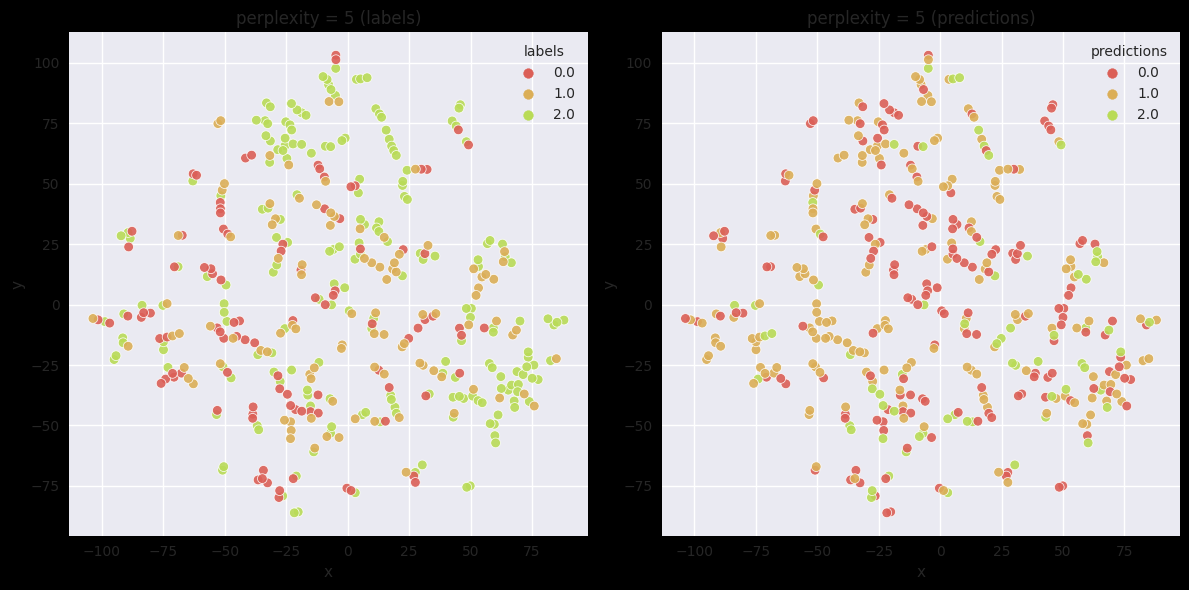

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.203s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.312960
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.107285
[t-SNE] KL divergence after 5000 iterations: 1.523582


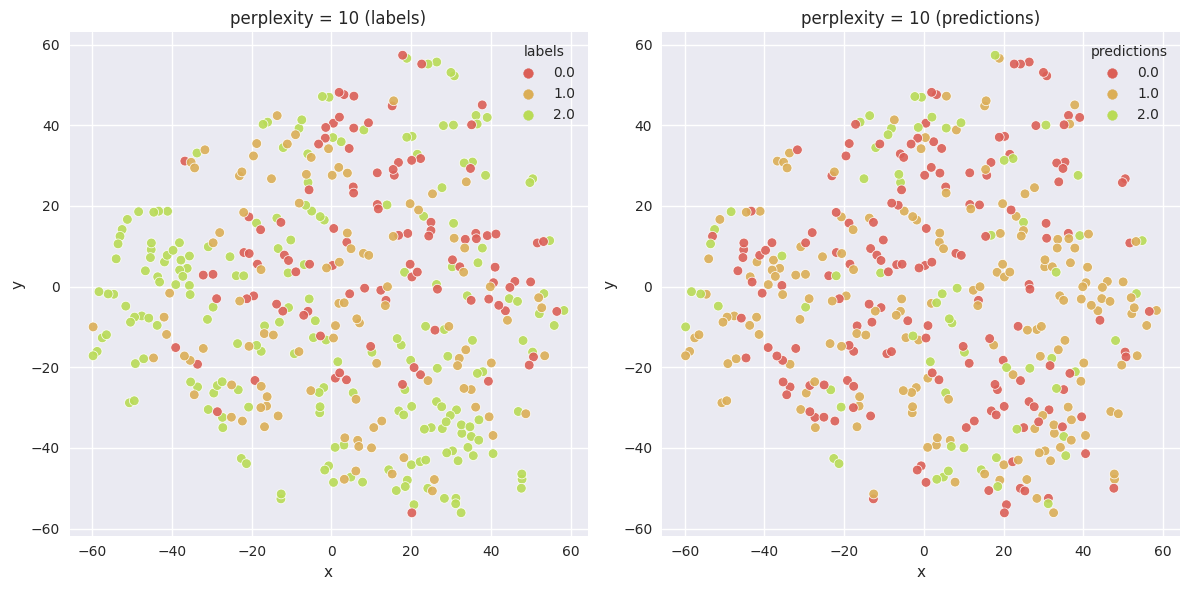

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.001s...
[t-SNE] Computed neighbors for 400 samples in 0.228s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.350087
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.212784
[t-SNE] KL divergence after 2250 iterations: 1.487344


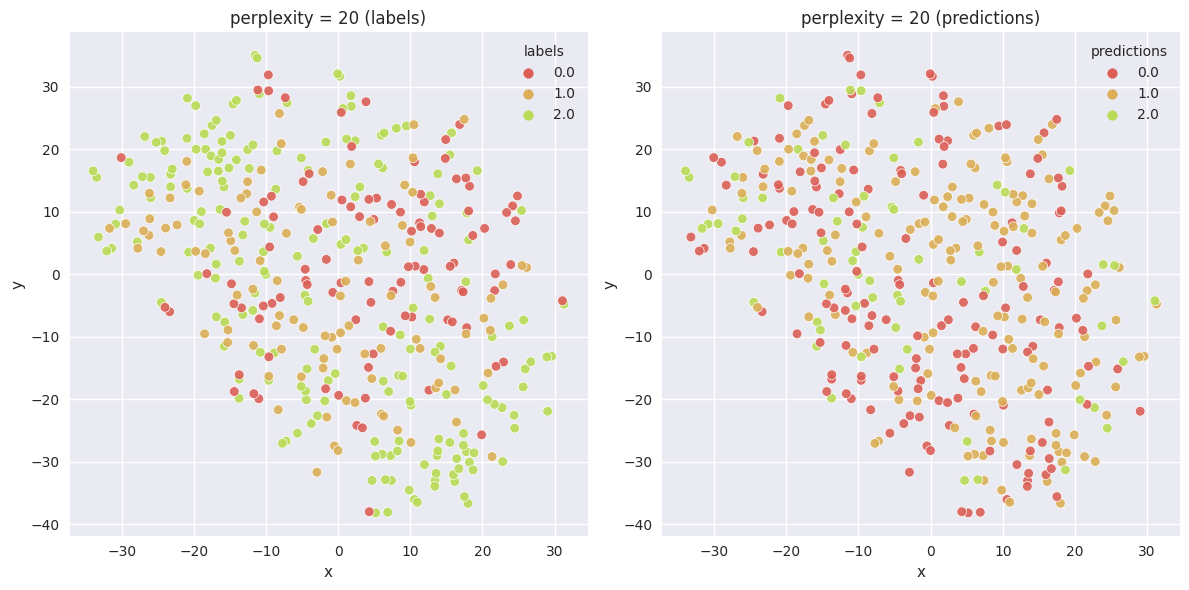

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.001s...
[t-SNE] Computed neighbors for 400 samples in 0.232s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.369091
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.556145


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

for perplexity in [5, 10, 20, 30, 40, 50]:
    tsne = TSNE(n_components=2, random_state=0, verbose=1, perplexity=perplexity, n_iter=5000)
    tsne_results = tsne.fit_transform(all_embeddings)

    tsne_df = pd.DataFrame(np.c_[tsne_results, labels.astype(np.uint8), predictions.astype(np.uint8)], 
                           columns=['x', 'y', 'labels', 'predictions'])

    plt.figure(figsize=(12, 6))
    plt.style.use('seaborn')

    # Plot with labels as hue
    plt.subplot(1, 2, 1)
    sns.scatterplot(
        x="x", y="y",
        hue="labels",
        palette=sns.color_palette("hls", 10),
        data=tsne_df,
        legend="full",
        alpha=0.9
    )
    plt.title("perplexity = " + str(perplexity) + " (labels)")

    # Plot with predictions as hue
    plt.subplot(1, 2, 2)
    sns.scatterplot(
        x="x", y="y",
        hue="predictions",
        palette=sns.color_palette("hls", 10),
        data=tsne_df,
        legend="full",
        alpha=0.9
    )
    plt.title("perplexity = " + str(perplexity) + " (predictions)")
    plt.tight_layout()
    plt.show()


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.454s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.262626
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.999687
[t-SNE] KL divergence after 5000 iterations: 1.293434


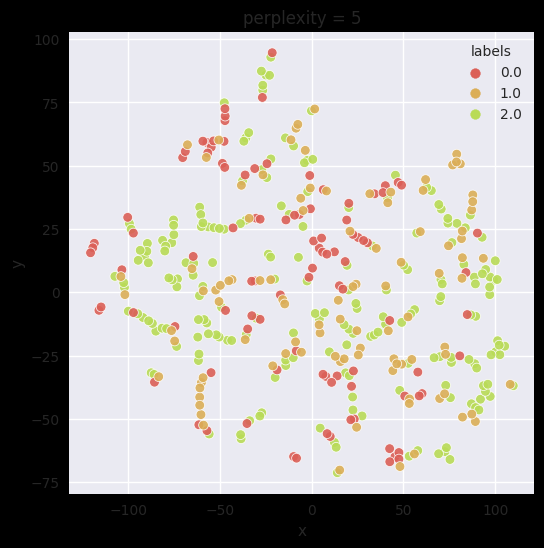

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.193s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.312544
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.732010
[t-SNE] KL divergence after 5000 iterations: 1.416770


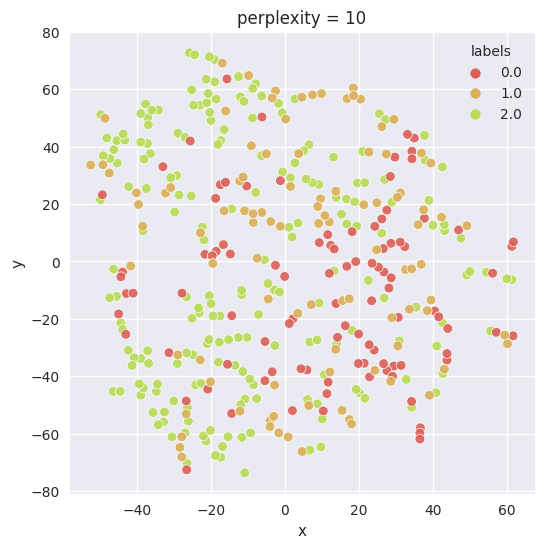

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.203s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.352283
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.729210
[t-SNE] KL divergence after 4000 iterations: 1.425746


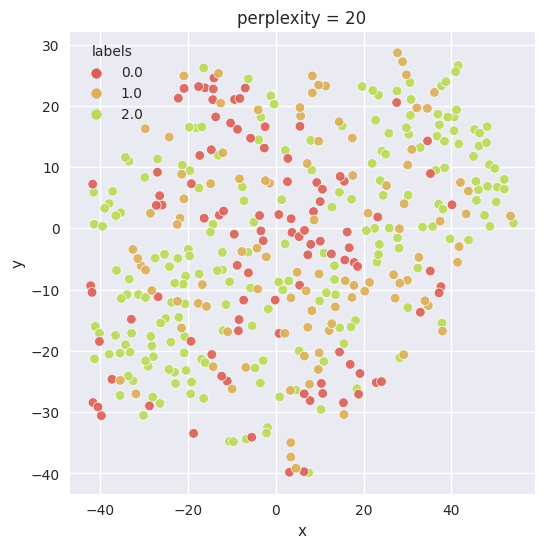

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.182s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.372622
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.003208
[t-SNE] KL divergence after 2000 iterations: 1.339564


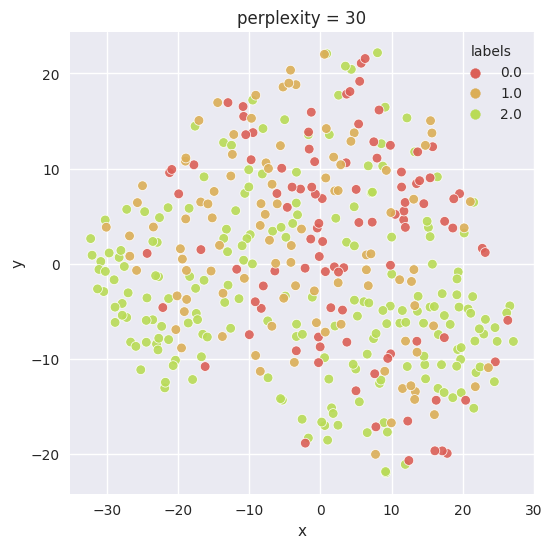

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.001s...
[t-SNE] Computed neighbors for 400 samples in 0.204s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.386287
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.644218
[t-SNE] KL divergence after 2150 iterations: 1.246136


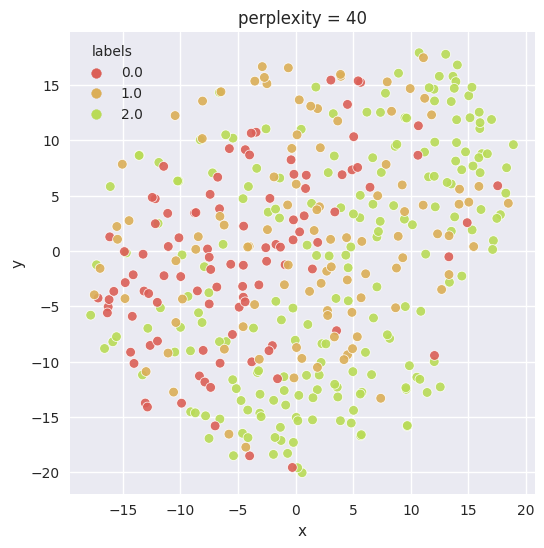

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.207s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.396684
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.039204
[t-SNE] KL divergence after 2500 iterations: 1.208990


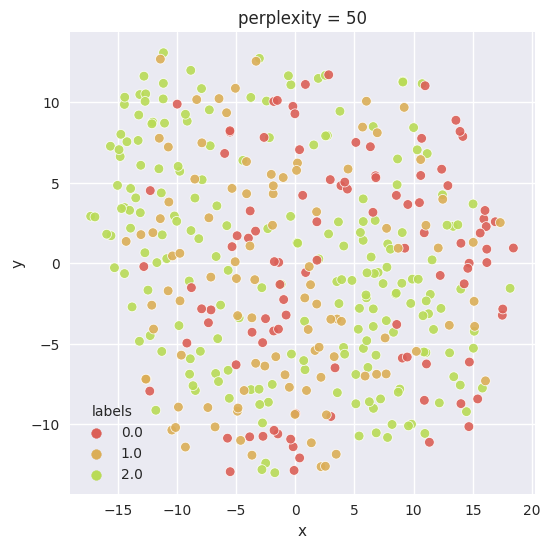

In [11]:
# With PCA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=50)  # You can adjust the number of components as needed
pca_results = pca.fit_transform(all_embeddings)

for perplexity in [5, 10, 20, 30, 40, 50]:
    tsne = TSNE(n_components=2, random_state=0, verbose=1, perplexity=perplexity, n_iter=5000)

    tsne_results = tsne.fit_transform(pca_results)  # Using PCA results

    tsne_df = pd.DataFrame(np.c_[tsne_results, labels.astype(np.uint8)], 
                        columns=['x', 'y', 'labels'])

    plt.figure(figsize=(6, 6))
    plt.style.use('seaborn')
    sns.scatterplot(
        x="x", y="y",
        hue="labels",
        palette=sns.color_palette("hls", 10),
        data=tsne_df,
        legend="full",
        alpha=0.9
    )
    plt.title("perplexity = " + str(perplexity))
    plt.show()
